# Comparing matrix factorization with transformers for MovieLens recommendations using PyTorch-accelerated.

By Chris Hughes

The package versions used are:

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import torch
from tqdm.notebook import tqdm
import time
import datetime
import os

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_joke_df = pd.read_csv(r'data\recsys-in-practice\train_joke_df.csv')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_df, valid_df = train_test_split(train_joke_df, test_size=0.3, random_state=42)

Even when considering model benchmarks on the same dataset, to have a fair comparison, it is important to understand how the data has been split and to make sure that the approaches taken are consistent!

In [6]:
user_lookup = {v: i+1 for i, v in enumerate(train_joke_df["UID"].unique())}

In [7]:
movie_lookup = {v: i+1 for i, v in enumerate(train_joke_df["JID"].unique())}

Now that we can encode our features, as we are using PyTorch, we need to define a Dataset to wrap our DataFrame and return the user-item ratings.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
from torch.utils.data import Dataset

class UserItemRatingDataset(Dataset):
    def __init__(self, df, movie_lookup, user_lookup):
        self.df = df
        self.movie_lookup = movie_lookup
        self.user_lookup = user_lookup

    def __getitem__(self, index):
        row = self.df.iloc[index]
        user_id = torch.tensor(self.user_lookup[row.UID]).to(device)
        movie_id = torch.tensor(self.movie_lookup[row.JID]).to(device)
        
        rating = torch.tensor(row.Rating, dtype=torch.float32).to(device)
        
        return (user_id, movie_id), rating

    def __len__(self):
        return len(self.df)


We can now use this to create our training and validation datasets:

In [10]:
train_dataset = UserItemRatingDataset(train_df, movie_lookup, user_lookup)
valid_dataset = UserItemRatingDataset(valid_df, movie_lookup, user_lookup)

Next, let's define the model.

In [11]:
import torch
from torch import nn

class MfDotBias(nn.Module):

    def __init__(self, n_factors, n_users, n_items, ratings_range=None, use_biases=True):
        super().__init__()
        self.bias = use_biases
        self.y_range = ratings_range
        self.user_embedding = nn.Embedding(n_users+1, n_factors, padding_idx=0)
        self.item_embedding = nn.Embedding(n_items+1, n_factors, padding_idx=0)

        if use_biases:
            self.user_bias = nn.Embedding(n_users+1, 1, padding_idx=0)
            self.item_bias = nn.Embedding(n_items+1, 1, padding_idx=0)

    def forward(self, inputs):
        users, items = inputs
        dot = self.user_embedding(users) * self.item_embedding(items)
        result = dot.sum(1)
        if self.bias:
            result = (result + self.user_bias(users).squeeze() + self.item_bias(items).squeeze())

        if self.y_range is None:
            return result
        else:
            return (torch.sigmoid(result) * (self.y_range[1] - self.y_range[0]) + self.y_range[0])

As we can see, this is very simple to define. Note that because an embedding layer is simply a lookup table, it is important that when we specify the size of the embedding layer, it must contain any value that will be seen during training and evaluation. Because of this, we will use the number of unique items observed in the full dataset to do this, not just the training set. We have also specified a padding embedding at index 0, which can be used for any unknown values. PyTorch handles this by setting this entry to a zero-vector, which is not updated during training.

Additionally, as this is a regression task, the range that the model could predict is potentially unbounded. While the model can learn to restrict the output values to between 1 and 5, we can make this easier for the model by modifying the architecture to restrict this range prior to training. We have done this by applying the sigmoid function to the model's output - which restricts the range to between 0 and 1 - and then scaling this to within a range that we can define.

### Train with PyTorch accelerated

At this point, we would usually start writing the training loop; however, as we are using pytorch-accelerated, this will largely be taken care of for us. However, as pytorch-accelerated tracks only the training and validation losses by default, let's create a callback to track our metrics.

Let's create a callback to track our metrics

Now, all that is left to do is to train the model. PyTorch-accelerated provides a notebook_launcher function, which enables us to run multi-GPU training runs from within a notebook. To use this, all we need to do is to define a training function that instantiates our Trainer object and calls the train method.

Components such as the model and dataset can be defined anywhere in the notebook, but it is important that the trainer is only ever instantiated within a training function.

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def save(model, name):
    os.mkdir(f"artifacts_wonderfund_v1loss/{name}")
    #torch.save(model, f"{name}/model.pkl")
    torch.save(model.state_dict(), f"artifacts_wonderfund_v1loss/{name}/checkpoint.pth")
    
def load(name):
    return torch.load(f"artifacts_wonderfund_v1loss/{name}/model.pkl")

def load2(name, model):
    model.load_state_dict(torch.load(f"artifacts_wonderfund_v1loss/{name}/checkpoint.pth"))
    
def train_model(epoch_start, model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler, loss_train_history, 
                loss_val_history, val_loss):   
    bet_model_name = None
    best_loss = compute_accuracy(model, val_loader, val_loss)
    print('loss:', best_loss)
    for epoch in range(epoch_start, epoch_start + num_epochs):     
        t1 = time.time()
        model.train()   
        loss_accum = 0
        for i_step, (x, y) in enumerate(tqdm(train_loader)):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()            
            loss_accum += loss_value

            
        
        ave_loss = loss_accum / (i_step + 1)
        loss_val = compute_accuracy(model, val_loader, val_loss)
        
        loss_train_history.append(float(ave_loss))
        loss_val_history.append(loss_val)
        
        if scheduler != None:
            scheduler.step(loss_val)
            

        if loss_val < best_loss:
            best_loss = loss_val
            bet_model_name = f'{datetime.datetime.now().strftime("%d.%m.%Y_%H.%M.%S.%f")}_epoch_{epoch}_loss_{round(best_loss, 4)}'
            save(model, bet_model_name)
            print(f"saved {bet_model_name}")

            
        print("Epoch: %i lr: %f; Train loss: %f, Val loss: %f, time: %i s" % (epoch, get_lr(optimizer), ave_loss, loss_val,
                                                                            round(time.time() - t1)))
    return bet_model_name
        
    
def compute_accuracy(model, loader, loss):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    loss_accum = 0
    for i_step, (x, y) in enumerate(tqdm(loader)):
        prediction = model(x)
        loss_value = loss(prediction, y)
        loss_accum += loss_value

    ave_loss = loss_accum / (i_step + 1)         
    return float(ave_loss)

In [13]:
def RMSE_loss(prediction, target):
    return torch.sqrt(nn.MSELoss()(prediction, target))

In [14]:
model = MfDotBias(120, len(user_lookup), len(movie_lookup), ratings_range=[-10, 10]).to(device)
loss_train_history, loss_val_history = [], []

#best_model_name = '22.04.2023_19.04.16.683005_epoch_14_loss_5.6441'
#load2(best_model_name, model)

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)
loss = nn.MSELoss()
val_loss = RMSE_loss

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

bet_model_name = train_model(8,
    model, 
    DataLoader(train_dataset, batch_size=10000),
    DataLoader(valid_dataset, batch_size=10000),
    loss, optimizer, 100, scheduler, loss_train_history, loss_val_history, val_loss=RMSE_loss)
print('end!')

  0%|          | 0/44 [00:00<?, ?it/s]

loss: 10.492141723632812


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_16.18.24.268741_epoch_8_loss_10.3978
Epoch: 8 lr: 0.010000; Train loss: 83.877396, Val loss: 10.397791, time: 343 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_16.24.03.209458_epoch_9_loss_10.163
Epoch: 9 lr: 0.010000; Train loss: 84.859505, Val loss: 10.163009, time: 339 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_16.29.44.405550_epoch_10_loss_9.9727
Epoch: 10 lr: 0.010000; Train loss: 76.617691, Val loss: 9.972737, time: 341 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_16.35.29.073594_epoch_11_loss_9.7034
Epoch: 11 lr: 0.010000; Train loss: 69.896904, Val loss: 9.703386, time: 345 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_16.41.12.263871_epoch_12_loss_9.2481
Epoch: 12 lr: 0.010000; Train loss: 62.574413, Val loss: 9.248148, time: 343 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_16.47.00.627349_epoch_13_loss_8.244
Epoch: 13 lr: 0.010000; Train loss: 53.045670, Val loss: 8.243999, time: 348 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_16.52.50.284598_epoch_14_loss_6.9422
Epoch: 14 lr: 0.010000; Train loss: 40.196411, Val loss: 6.942152, time: 350 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_16.58.35.284571_epoch_15_loss_6.0961
Epoch: 15 lr: 0.010000; Train loss: 29.887051, Val loss: 6.096142, time: 345 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_17.04.17.068790_epoch_16_loss_5.5041
Epoch: 16 lr: 0.010000; Train loss: 23.806854, Val loss: 5.504140, time: 342 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_17.10.03.966972_epoch_17_loss_5.2197
Epoch: 17 lr: 0.010000; Train loss: 20.495747, Val loss: 5.219734, time: 347 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_17.15.50.354030_epoch_18_loss_5.0477
Epoch: 18 lr: 0.010000; Train loss: 18.369164, Val loss: 5.047692, time: 346 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_17.21.30.654471_epoch_19_loss_4.9148
Epoch: 19 lr: 0.010000; Train loss: 16.639517, Val loss: 4.914762, time: 340 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

saved 25.04.2023_17.27.09.931216_epoch_20_loss_4.8991
Epoch: 20 lr: 0.010000; Train loss: 15.163802, Val loss: 4.899110, time: 339 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 21 lr: 0.010000; Train loss: 14.027334, Val loss: 4.923078, time: 343 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 22 lr: 0.010000; Train loss: 12.945564, Val loss: 4.952038, time: 342 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 23 lr: 0.010000; Train loss: 11.947998, Val loss: 5.015331, time: 343 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 24 lr: 0.001000; Train loss: 11.009702, Val loss: 5.088777, time: 341 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 25 lr: 0.001000; Train loss: 10.825204, Val loss: 4.944238, time: 340 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 26 lr: 0.001000; Train loss: 9.817195, Val loss: 4.912767, time: 348 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 27 lr: 0.001000; Train loss: 9.564724, Val loss: 4.903979, time: 345 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 28 lr: 0.000100; Train loss: 9.418543, Val loss: 4.902838, time: 348 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 29 lr: 0.000100; Train loss: 9.095663, Val loss: 4.902237, time: 345 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 30 lr: 0.000100; Train loss: 9.077843, Val loss: 4.901780, time: 345 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 31 lr: 0.000100; Train loss: 9.060753, Val loss: 4.901438, time: 349 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 32 lr: 0.000010; Train loss: 9.044175, Val loss: 4.901201, time: 343 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 33 lr: 0.000010; Train loss: 9.005652, Val loss: 4.901179, time: 345 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 34 lr: 0.000010; Train loss: 9.003963, Val loss: 4.901158, time: 344 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 35 lr: 0.000010; Train loss: 9.002233, Val loss: 4.901139, time: 347 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 36 lr: 0.000001; Train loss: 9.000457, Val loss: 4.901119, time: 350 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 37 lr: 0.000001; Train loss: 8.996335, Val loss: 4.901116, time: 348 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 38 lr: 0.000001; Train loss: 8.996148, Val loss: 4.901114, time: 339 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 39 lr: 0.000001; Train loss: 8.995957, Val loss: 4.901113, time: 338 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 40 lr: 0.000000; Train loss: 8.995761, Val loss: 4.901110, time: 336 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 41 lr: 0.000000; Train loss: 8.995323, Val loss: 4.901110, time: 338 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 42 lr: 0.000000; Train loss: 8.995312, Val loss: 4.901110, time: 337 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 43 lr: 0.000000; Train loss: 8.995299, Val loss: 4.901110, time: 336 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 44 lr: 0.000000; Train loss: 8.995283, Val loss: 4.901110, time: 340 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 45 lr: 0.000000; Train loss: 8.995244, Val loss: 4.901110, time: 338 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 46 lr: 0.000000; Train loss: 8.995244, Val loss: 4.901110, time: 339 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 47 lr: 0.000000; Train loss: 8.995244, Val loss: 4.901110, time: 338 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 48 lr: 0.000000; Train loss: 8.995244, Val loss: 4.901110, time: 339 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 49 lr: 0.000000; Train loss: 8.995244, Val loss: 4.901110, time: 339 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 50 lr: 0.000000; Train loss: 8.995242, Val loss: 4.901110, time: 337 s


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 51 lr: 0.000000; Train loss: 8.995241, Val loss: 4.901110, time: 338 s


  0%|          | 0/102 [00:00<?, ?it/s]

KeyboardInterrupt: 

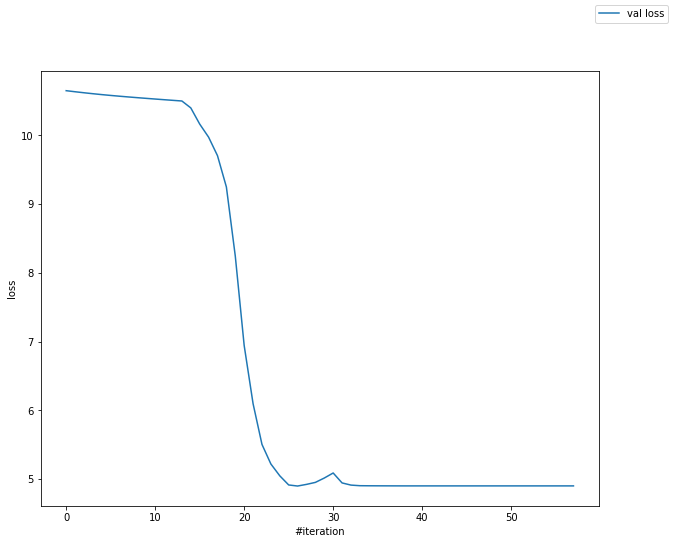

In [25]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_val_history, label='val loss')
fig.legend()
plt.show()

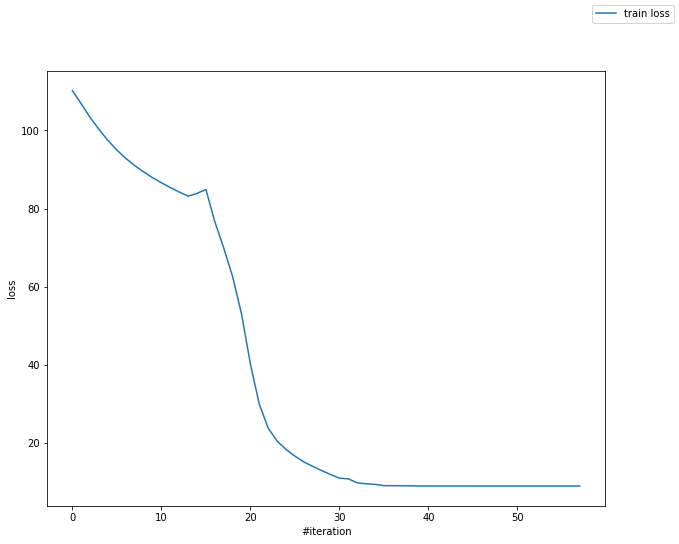

In [26]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_train_history, label='train loss')
fig.legend()
plt.show()

In [ ]:
assert False

In [ ]:
dataset = UserItemRatingDataset(train_joke_df, movie_lookup, user_lookup)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

bet_model_name = train_model(21,
    model, 
    DataLoader(dataset, batch_size=10000),
    DataLoader(valid_dataset, batch_size=10000),
    RMSE_loss, optimizer, 6, None, loss_train_history, loss_val_history)
print('end!')

In [ ]:
assert False

In [ ]:
test_joke_df_nofactrating = pd.read_csv(r'data\recsys-in-practice\test_joke_df_nofactrating.csv', index_col=0)

test_joke_df_nofactrating['Rating'] = np.zeros((len(test_joke_df_nofactrating)))

In [ ]:
test_dataset = UserItemRatingDataset(test_joke_df_nofactrating, movie_lookup, user_lookup)

In [ ]:
best_model_name = '22.04.2023_22.36.11.670000_epoch_25_loss_4.8642'

best_model = MfDotBias(120, len(user_lookup), len(movie_lookup), ratings_range=[-10, 10]).to(device)
print(compute_accuracy(best_model, DataLoader(test_dataset, batch_size=5000), RMSE_loss))

load2(best_model_name, best_model)
print(compute_accuracy(best_model, DataLoader(test_dataset, batch_size=5000), RMSE_loss))

In [ ]:
result = []
for x, y in tqdm(DataLoader(test_dataset, batch_size=5000)):
    predict = model(x)
    result.extend(predict.cpu().detach().numpy())

In [ ]:
test_joke_df_nofactrating['Rating'] = result

In [ ]:
test_joke_df_nofactrating['Rating'].to_frame().head(5)

In [ ]:
test_joke_df_nofactrating['Rating'].to_frame().to_csv('nn_embedding.csv')

In [ ]:
assert False